In [1]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from typing import Annotated
from typing import Literal
from pydantic import Field
import math
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import BaseTool, BaseToolkit, tool
from langgraph.prebuilt import tools_condition, ToolNode
from pydantic import BaseModel
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph.message import MessagesState, add_messages
from langchain_core.messages import HumanMessage, SystemMessage

load_dotenv()

os.environ["LANGSMITH_PROJECT"] = "calculator"

mermaid_url = 'http://localhost:3000'

## Hloupá kalkulačka

### 1. Definice stavu agenta

In [2]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

### 2. Definice vrcholů, hran a grafu

In [3]:
llm = init_chat_model("google_genai:gemini-2.0-flash")


def invoke_llm_node(state: AgentState):
    ai_message = llm.invoke(state["messages"])

    return {"messages": [ai_message]}


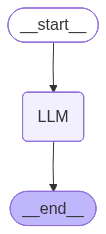

In [4]:
graph_builder = (
    StateGraph(AgentState)
    # nodes
    .add_node("LLM", invoke_llm_node)
    # edges
    .add_edge(START, "LLM")
    .add_edge("LLM", END)
)

# kompilace grafu
graph = graph_builder.compile()

# vizualizace
Image(graph.get_graph().draw_mermaid_png())

### 3. Invoke
- (drobná) nepřesnost výsledku

In [ ]:
response = graph.invoke(
    {"messages": [
        SystemMessage("You are a math calculator assistant that helps calculating given equations and expressions. Before calculating, think about the correct order of operations (PEMDAS/BODMAS) and make use of interim results."),
        HumanMessage("What is (40+3.69)/0.7584*sqrt(99/4.98)?")
    ]}
)

for message in response["messages"]:
    message.pretty_print()

# print(f"Final result: {response['result']}")
# 256,8541851

================================ System Message ================================

You are a math calculator assistant that helps calculating given equations and expressions. Before calculating, think about the correct order of operations (PEMDAS/BODMAS) and make use of interim results.
================================ Human Message =================================

What is (40+3.69)/0.7584*sqrt(99/4.98)?
================================== Ai Message ==================================

Here's how to calculate the expression step-by-step, following the order of operations (PEMDAS/BODMAS):

1.  **Parentheses/Brackets:**
    *   40 + 3.69 = 43.69

2.  **Parentheses/Brackets (inside sqrt):**
    *   99 / 4.98 = 19.8795

3.  **Square Root:**
    *   sqrt(19.8795) = 4.4586

4.  **Division:**
    *   43.69 / 0.7584 = 57.6079

5.  **Multiplication:**
    *   57.6079 * 4.4586 = 256.8715

Therefore, (40+3.69)/0.7584*sqrt(99/4.98) =  **256.8715**


## Zchytření kalkulačky o tooly

### 2. Definice toolů, vrcholů, hran a grafu

In [6]:
llm = init_chat_model("google_genai:gemini-2.0-flash")


class CalculatorToolkit:
    def get_tools(self):
        return [self.multiply, self.divide, self.add, self.subtract, self.power, self.sqrt]

    @staticmethod
    @tool
    def multiply(a: float, b: float) -> float:
        """Multiply two numbers."""
        return a * b

    @staticmethod
    @tool
    def divide(a: float, b: float) -> float:
        """Divide number `a` by `b`."""
        return a / b

    @staticmethod
    @tool
    def add(a: float, b: float) -> float:
        """Add numbers `a` and `b` together."""
        return a + b

    @staticmethod
    @tool
    def subtract(a: float, b: float) -> float:
        """Subtract number `b` from `a`."""
        return a - b

    @staticmethod
    @tool
    def power(a: float, b: float) -> float:
        """Raise number `a` to the power of `b`."""
        return a**b

    @staticmethod
    @tool
    def sqrt(a: float) -> float:
        """Calculate the square root of the number `a`."""
        return math.sqrt(a)


calculator_toolkit = CalculatorToolkit()


def invoke_llm_node(state: AgentState):
    llm_with_tools = llm.bind_tools(calculator_toolkit.get_tools())
    ai_message = llm_with_tools.invoke(state["messages"])

    return {"messages": [ai_message]}


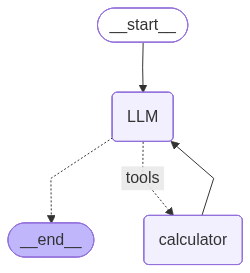

In [7]:
graph_builder = (
    StateGraph(AgentState)
    # nodes
    .add_node("LLM", invoke_llm_node)
    .add_node("calculator", ToolNode(calculator_toolkit.get_tools()))
    # edges
    .add_edge(START, "LLM")
    .add_conditional_edges(
        "LLM", tools_condition,
        {"tools": "calculator", END: END}
    )
    .add_edge("calculator", "LLM")
    .add_edge("LLM", END)
)

# kompilace grafu
graph = graph_builder.compile()

# vizualizace
Image(graph.get_graph().draw_mermaid_png(base_url=mermaid_url))

### 3. Invoke

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

response = graph.invoke(
    {"messages": [
        SystemMessage("You are a math calculator assistant that helps calculating given equations and expressions. Before calculating, think about the correct order of operations (PEMDAS/BODMAS) and make use of interim results."),
        HumanMessage("What is (40+3.69)/0.7584*sqrt(99/4.98)?")
    ]},
)

for message in response["messages"]:
    message.pretty_print()

================================ System Message ================================

You are a math calculator assistant that helps calculating given equations and expressions. Before calculating, think about the correct order of operations (PEMDAS/BODMAS) and make use of interim results.
================================ Human Message =================================

What is (40+3.69)/0.7584*sqrt(99/4.98)?
================================== Ai Message ==================================
Tool Calls:
  add (44f3d15e-a88e-4b9f-b448-6c50c2f4fc14)
 Call ID: 44f3d15e-a88e-4b9f-b448-6c50c2f4fc14
  Args:
    b: 3.69
    a: 40.0
================================= Tool Message =================================
Name: add

43.69
================================== Ai Message ==================================
Tool Calls:
  divide (aa81a4f3-825e-4eb6-8dbf-7fde4316ff27)
 Call ID: aa81a4f3-825e-4eb6-8dbf-7fde4316ff27
  Args:
    b: 0.7584
    a: 43.69
================================= Tool Message ======

## Strukturované parsování výsledku

### 2. Definice vrcholů, hran a grafu

In [9]:
class StructuredStep(BaseModel):
    a: float
    b: float | None = None
    operation: Literal["/", "*", "+", "-", "^", "sqrt"] = Field(
        description="The operation that was performed in this step (as a symbol)."
    )
    result: float = Field(description="The result of that operation.")


class StructuredResult(BaseModel):
    steps: list[StructuredStep] = Field(
        default_factory=list,
        description="A list of all the steps that were performed to calculate the final result.",
    )
    result: float = Field(description="The final result of the calculation.")


class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    result: StructuredResult | None = None


def parse_results_node(state: AgentState):
    state["messages"].append(
        HumanMessage(
            "Based on the previous thought process of a calculator agent, extract the intermediate steps and the final result."
        )
    )
    llm_with_structured_output = llm.with_structured_output(StructuredResult)
    result = llm_with_structured_output.invoke(state["messages"])

    return {
        **state,
        "result": result,
    }


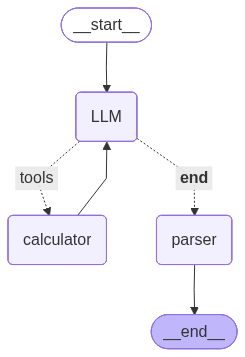

In [10]:
graph_builder = (
    StateGraph(AgentState)
    # nodes
    .add_node("LLM", invoke_llm_node)
    .add_node("calculator", ToolNode(calculator_toolkit.get_tools()))
    .add_node("parser", parse_results_node)
    # edges
    .add_edge(START, "LLM")
    .add_conditional_edges(
        "LLM", tools_condition,
        {"tools": "calculator", END: "parser"}
    )
    .add_edge("calculator", "LLM")
    .add_edge("parser", END)
)

# kompilace grafu
graph = graph_builder.compile()

# vizualizace
Image(graph.get_graph().draw_mermaid_png(base_url=mermaid_url))

### 3. Invoke

In [11]:
from langchain_core.messages import HumanMessage, SystemMessage

response = graph.invoke(
    {"messages": [
        SystemMessage("You are a math calculator assistant that helps calculating given equations and expressions. Before calculating, think about the correct order of operations (PEMDAS/BODMAS) and make use of interim results."),
        HumanMessage("What is (40+3.69)/0.7584*sqrt(99/4.98)?")
    ]},
)
for message in response["messages"]:
    message.pretty_print()

================================ System Message ================================

You are a math calculator assistant that helps calculating given equations and expressions. Before calculating, think about the correct order of operations (PEMDAS/BODMAS) and make use of interim results.
================================ Human Message =================================

What is (40+3.69)/0.7584*sqrt(99/4.98)?
================================== Ai Message ==================================
Tool Calls:
  add (dabdb5fa-573c-4d19-81c7-53d4811624be)
 Call ID: dabdb5fa-573c-4d19-81c7-53d4811624be
  Args:
    b: 3.69
    a: 40.0
================================= Tool Message =================================
Name: add

43.69
================================== Ai Message ==================================
Tool Calls:
  divide (41ee1b98-cc5a-4200-9aa7-c5d76355ee40)
 Call ID: 41ee1b98-cc5a-4200-9aa7-c5d76355ee40
  Args:
    b: 4.98
    a: 99.0
================================= Tool Message =========

In [12]:
response

{'messages': [SystemMessage(content='You are a math calculator assistant that helps calculating given equations and expressions. Before calculating, think about the correct order of operations (PEMDAS/BODMAS) and make use of interim results.', additional_kwargs={}, response_metadata={}, id='3862fc80-5876-467c-a6d0-62efaa565a29'),
  HumanMessage(content='What is (40+3.69)/0.7584*sqrt(99/4.98)?', additional_kwargs={}, response_metadata={}, id='63055485-49d3-4629-aeca-5f9c787f034c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"b": 3.69, "a": 40.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--bb7b1fb3-beca-4509-b939-9fc48fce5bb5-0', tool_calls=[{'name': 'add', 'args': {'b': 3.69, 'a': 40.0}, 'id': 'dabdb5fa-573c-4d19-81c7-53d4811624be', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 5

In [13]:
for i, step in enumerate(response["result"].steps):
    if step.operation == "sqrt":
        print(f"Step {i+1}: sqrt({step.a}) = {step.result}")
    else:
        print(f"Step {i+1}: {step.a} {step.operation} {step.b} = {step.result}")

print("=", response["result"].result)

Step 1: 40.0 + 3.69 = 43.69
Step 2: 99.0 / 4.98 = 19.879518072289155
Step 3: sqrt(19.879518072289155) = 4.4586453180634535
Step 4: 43.69 / 0.7584 = 57.608122362869196
Step 5: 57.608122362869196 * 4.4586453180634535 = 256.85418505563325
= 256.85418505563325
